Name: Saman Akhtar USC ID: 9944619932

**Imports**

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn import metrics
import math
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
import statsmodels.api as stat
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import Normalizer

# pip install javabridge
# pip install python-weka-wrapper3
import weka.core.jvm as jvm
from weka.classifiers import Classifier, Evaluation, PredictionOutput
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls
import javabridge
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

# 1. The LASSO and Boosting for Regression

## (a)  Download Communities and Crime Data :from  https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime . Use the first 1495 rows of data as the training set and the rest as the test set

In [96]:
cc_df = pd.read_csv('../data/communities.csv', header=None, na_values = '?')

In [97]:
attribute_df = pd.read_csv('../data/communitiesname.csv',sep=" ", header=None)
attribute_df.columns = ['attri', 'name', 'type']
attribute_df.shape

(128, 3)

In [98]:
cc_df.columns = attribute_df.name.values
cc_df.shape

(1994, 128)

In [99]:
cc_df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


##### Split data into Traing set

In [100]:
cc_train = cc_df.iloc[:1495,:]
cc_train.shape

(1495, 128)

In [101]:
cc_train.head(5)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


##### Split data into Test set

In [102]:
cc_test = cc_df.iloc[1495:,:]
cc_test.shape

(499, 128)

In [103]:
cc_test.head(5)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,6,NaN,NaN,MillValleycity,8,0.00,0.20,0.03,0.91,0.23,...,0.01,0.23,0.73,NaN,NaN,NaN,NaN,0.0,NaN,0.12
1496,48,NaN,NaN,LiveOakcity,8,0.00,0.55,0.13,0.78,0.15,...,0.01,0.18,0.02,NaN,NaN,NaN,NaN,0.0,NaN,0.11
1497,35,NaN,NaN,Portalescity,8,0.00,0.52,0.04,0.59,0.05,...,0.01,0.18,0.00,NaN,NaN,NaN,NaN,0.0,NaN,0.12
1498,42,17.0,25112.0,Fallstownship,8,0.04,0.51,0.07,0.92,0.09,...,0.06,0.13,0.16,NaN,NaN,NaN,NaN,0.0,NaN,0.06
1499,51,683.0,48952.0,Manassascity,8,0.03,0.59,0.20,0.75,0.19,...,0.03,0.23,0.06,NaN,NaN,NaN,NaN,0.0,NaN,0.12


## (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features. 

Removing first 5 non predictive features from the data set(given in data set description)

In [104]:
# Removing 'state','county','community','communityname','fold' from both training and testing data set
cc_train = cc_train.iloc[:, 5:] 
cc_test = cc_test.iloc[:, 5:] 
cc_test.shape

(499, 123)

Doing imputation on training and testing data separately so that testing data remains true to itself.. without being effected by mean of training data set

In [105]:
# Using SimpleImputer for completing the missing values in training data set
# By default mean is used for the startegy
imp_mean = SimpleImputer(missing_values=np.nan)
imp_mean = imp_mean.fit(cc_train)
cc_train_imp = imp_mean.transform(cc_train)
cc_train_imp

array([[0.19      , 0.33      , 0.02      , ..., 0.32      , 0.14      ,
        0.2       ],
       [0.        , 0.16      , 0.12      , ..., 0.        , 0.19075314,
        0.67      ],
       [0.        , 0.42      , 0.49      , ..., 0.        , 0.19075314,
        0.43      ],
       ...,
       [0.01      , 0.36      , 0.95      , ..., 0.        , 0.19075314,
        0.3       ],
       [0.06      , 0.53      , 0.01      , ..., 0.        , 0.19075314,
        0.03      ],
       [0.05      , 0.43      , 0.08      , ..., 0.51      , 0.18      ,
        0.23      ]])

In [106]:
# Adding the column back to imputed training df
cc_train_imp = pd.DataFrame(cc_train_imp,columns = attribute_df.iloc[5:].name.values)
cc_train_imp

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [107]:
# df = cc_test_imp.isna().sum()#.sort_values(ascending = False)
# df[df > 0]
cc_train_imp.isnull().any().any()

False

In [108]:
# Using SimpleImputer for completing the missing values in testing data set
# By default mean is used for the startegy
imp_mean = SimpleImputer(missing_values = np.nan)
imp_mean = imp_mean.fit(cc_test)
cc_test_imp = imp_mean.transform(cc_test)

# Adding the column back to imputed testing df
cc_test_imp = pd.DataFrame(cc_test_imp, columns = attribute_df.iloc[5:].name.values)
cc_test_imp.shape

(499, 123)

In [109]:
# Separating features and response
X_train = cc_train_imp.drop(columns = 'ViolentCrimesPerPop') 
Y_train =  cc_train_imp.ViolentCrimesPerPop
X_test = cc_test_imp.drop(columns = 'ViolentCrimesPerPop') 
Y_test = cc_test_imp.ViolentCrimesPerPop
X_train.shape

(1495, 122)

In [110]:
X_test.shape

(499, 122)

## (c) Plot a correlation matrix for the features in the data set. 

In [111]:
# Getting correlation matrix of all the features in the whole data set
features = pd.concat([X_train, X_test], ignore_index=True)
all_corr =  features.corr()
all_corr

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.110869,0.713652,0.231897,0.270356,0.609025,0.591863,-0.060176,0.075756,0.466352,-0.035108
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,0.027574,-0.015078,-0.004072,-0.051506,-0.032958,-0.009528,-0.011031,-0.002349,-0.094368,-0.052340
racepctblack,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,-0.049673,0.149758,0.095053,0.147023,0.121997,0.082672,-0.079922,0.010885,0.260793,0.022149
racePctWhite,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.026724,-0.131389,-0.337458,-0.215636,-0.109236,-0.114599,0.050180,-0.033414,-0.276234,-0.005907
racePctAsian,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,0.126550,-0.001084,0.389944,0.296921,-0.018025,0.067119,0.030704,0.064770,0.101888,-0.011324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PolicOperBudg,0.591863,-0.009528,0.082672,-0.114599,0.067119,0.060512,-0.019269,0.011067,-0.001448,-0.020628,...,0.141440,0.395093,0.130144,0.172266,0.799408,1.000000,-0.058583,0.034917,-0.062375,0.245440
LemasPctPolicOnPatr,-0.060176,-0.011031,-0.079922,0.050180,0.030704,0.024973,-0.003476,0.009213,0.012742,0.019504,...,0.094272,-0.071618,0.053388,0.026682,-0.107241,-0.058583,1.000000,0.035644,0.020296,-0.254718
LemasGangUnitDeploy,0.075756,-0.002349,0.010885,-0.033414,0.064770,0.026412,0.009440,0.003542,-0.001200,-0.036443,...,0.137413,0.106469,-0.076351,-0.080706,0.079727,0.034917,0.035644,1.000000,-0.015673,-0.032356
LemasPctOfficDrugUn,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,-0.027008,0.299632,0.228084,0.206644,-0.052428,-0.062375,0.020296,-0.015673,1.000000,0.018603


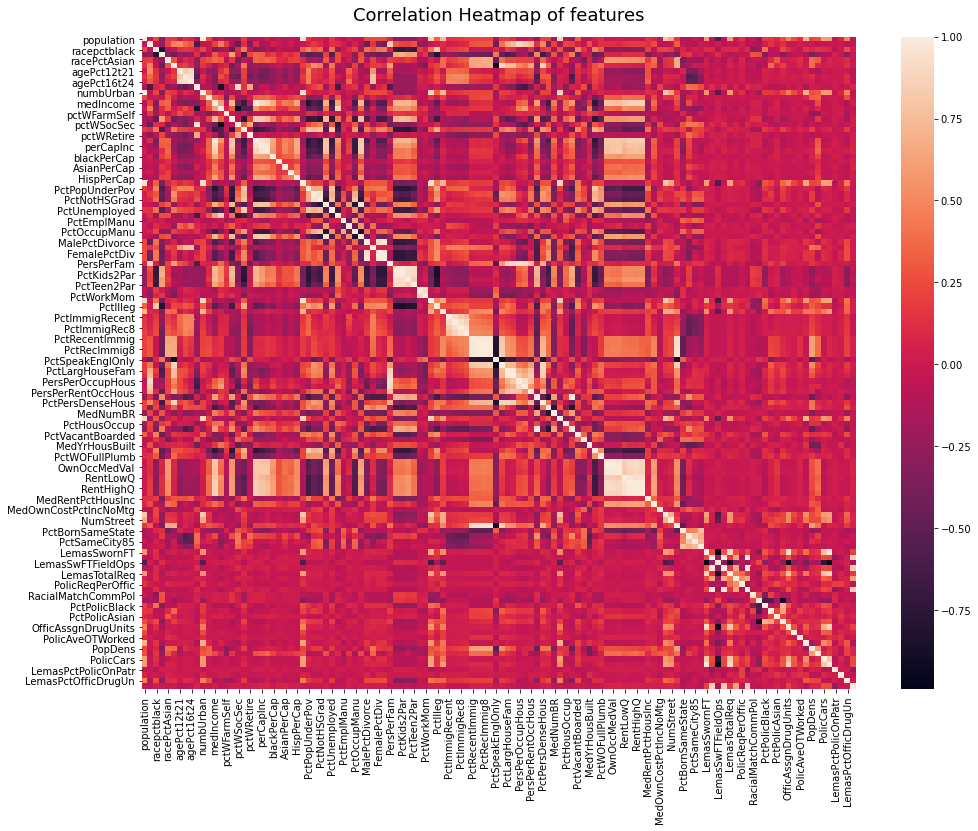

In [25]:
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(all_corr)
heatmap.set_title('Correlation Heatmap of features', fontdict={'fontsize':18}, pad=16);

## (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/ m , in which s is sample standard deviation and m is sample mean.

In [112]:
cv = features.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
cv

NumStreet              4.406597
NumInShelters          3.484607
NumIlleg               2.993446
NumImmig               2.899770
LemasPctOfficDrugUn    2.554625
                         ...   
NumKindsDrugsSeiz      0.146365
RacialMatchCommPol     0.132395
LemasPctPolicOnPatr    0.126610
PctPolicWhite          0.121682
LemasSwFTFieldOps      0.057891
Length: 122, dtype: float64

In [26]:

cv = X_train.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
cv

NumStreet              4.291487
NumInShelters          3.469791
NumIlleg               3.057941
NumImmig               2.925656
LemasPctOfficDrugUn    2.552092
                         ...   
NumKindsDrugsSeiz      0.144334
RacialMatchCommPol     0.134808
PctPolicWhite          0.122772
LemasPctPolicOnPatr    0.115700
LemasSwFTFieldOps      0.064266
Length: 122, dtype: float64

## (e) Pick b √ 128 c features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [113]:
# taking 11 features with best cv
best_feat = cv.head(11).index
print(" The 11 features with best cv is:\n",best_feat)


 The 11 features with best cv is:
 Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')


In [115]:
bestfeat_df = pd.concat([features.loc[:, best_feat], Y_train], axis= 'columns')
bestfeat_df

,NumStreet,NumInShelters,NumIlleg,NumImmig,LemasPctOfficDrugUn,NumUnderPov,population,numbUrban,HousVacant,LandArea,racePctHisp,ViolentCrimesPerPop
0,0.00,0.04,0.04,0.03,0.32,0.08,0.19,0.20,0.21,0.12,0.17,0.20
1,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.02,0.02,0.07,0.67
2,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.04,0.43
3,0.00,0.00,0.03,0.02,0.00,0.01,0.04,0.06,0.01,0.02,0.10,0.12
4,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.04,0.05,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.03,0.02,0.01,0.16,NaN
1990,0.00,0.01,0.03,0.05,0.00,0.04,0.05,0.06,0.03,0.02,0.32,NaN
1991,0.02,0.06,0.13,0.06,0.91,0.12,0.16,0.17,0.21,0.08,0.25,NaN
1992,0.01,0.04,0.02,0.06,0.22,0.03,0.08,0.09,0.05,0.03,0.10,NaN


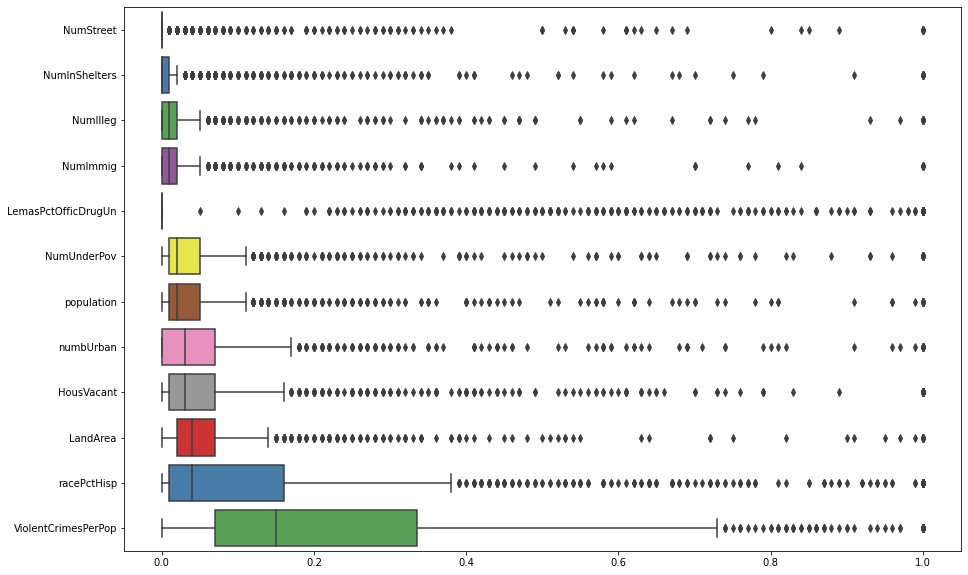

In [116]:
plt.figure(figsize=(15,10))
sns.boxplot(data=bestfeat_df, orient="h", palette="Set1")

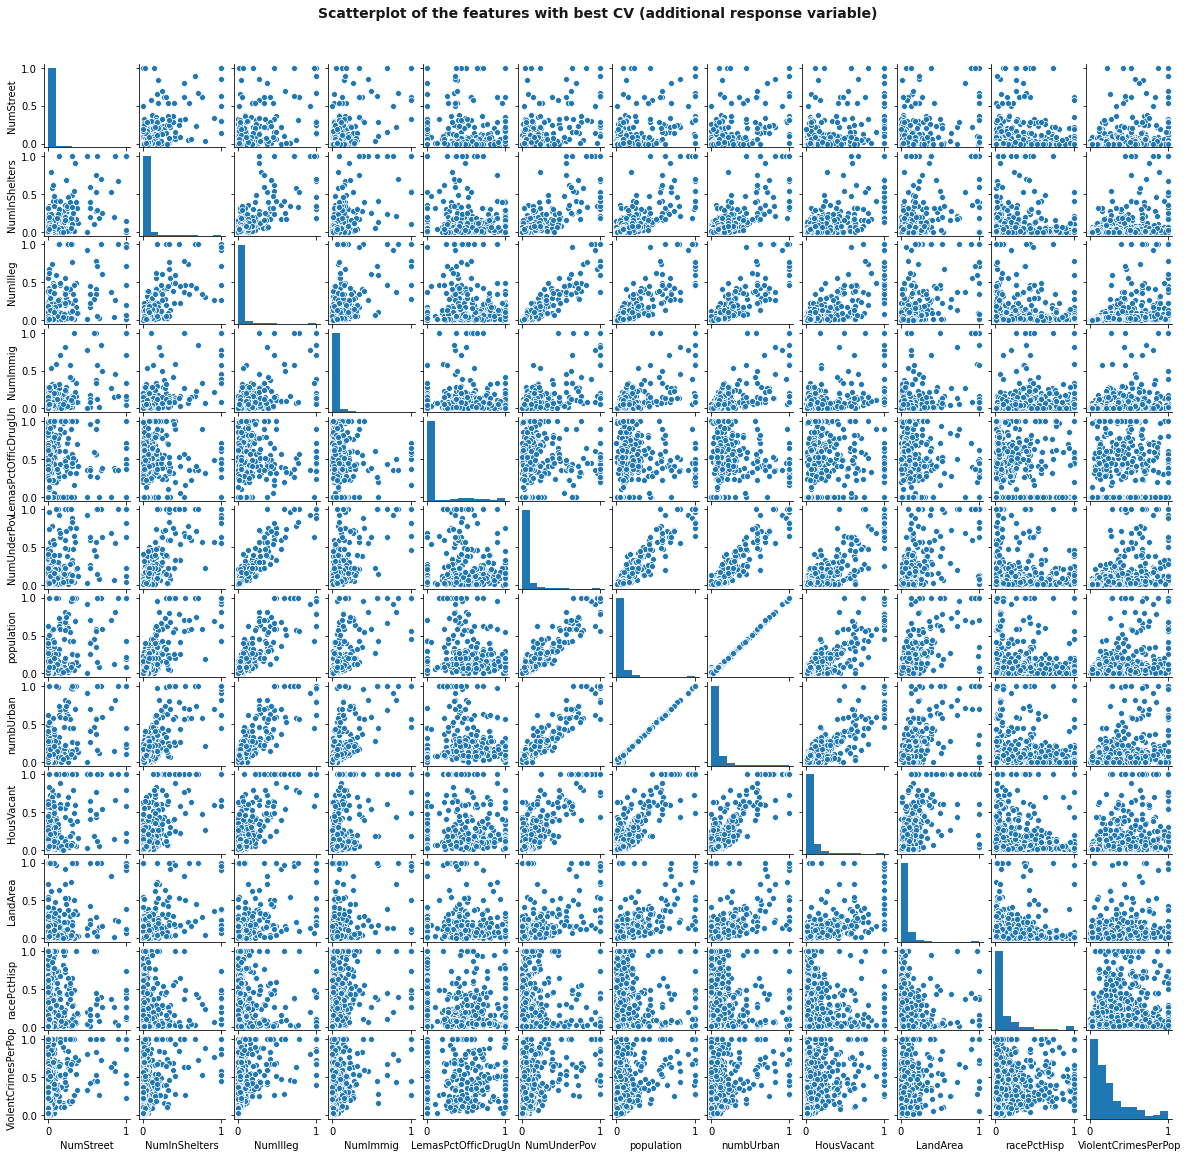

In [117]:
figure = sns.pairplot(bestfeat_df)
figure.fig.set_size_inches(16,16)
plt.subplots_adjust(top = .93 )
figure.fig.suptitle("Scatterplot of the features with best CV (additional response variable) ", fontsize = 14, alpha = 0.9, weight = 'bold')
plt.show()

The data points in most of the cases are spread across and thus difficult to find out pattern.
But following features have correlation between themselves:
1) Numlleg with NumUnderPov,population and numbUrban 
2) NumUnderPov with population and numburban
3) population with numbUrban shows strong clear linear relation
4) Housevacant has weak corelation with NumUnderPov,population and numbUrban 

##  (f) Fit a linear model using least squares to the training set and report the test error. 

In [31]:
# Using OLS to find significance 
model = stat.OLS(Y_train, X_train)
model_fit = model.fit()
p_val = model_fit.pvalues
p_val[p_val  < 0.01]

racepctblack             0.000002
pctUrban                 0.009788
pctWRetire               0.005453
PctPopUnderPov           0.006919
PctEmploy                0.000978
MalePctNevMarr           0.002007
PctWorkMom               0.001010
PctPersDenseHous         0.001026
PctVacantBoarded         0.001653
PctVacMore6Mos           0.002295
MedOwnCostPctIncNoMtg    0.003858
NumStreet                0.001923
dtype: float64

In [33]:
train_error = model_fit.mse_resid
print('Training Error of OLS: %0.4f' % train_error)
Y_pred = model_fit.predict(X_test)
test_error = sum((Y_test - Y_pred)**2)/(len(Y_pred))
print('Test Error of OLS: %0.4f' % test_error)

Training Error of OLS: 0.0177
Test Error of OLS: 0.0182


From the graph it was difficult to eyeball statistically signficant relationship. But from p values we get definite results

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared (uncentered):                   0.857
Model:                             OLS   Adj. R-squared (uncentered):              0.845
Method:                  Least Squares   F-statistic:                              68.25
Date:                 Sun, 04 Jul 2021   Prob (F-statistic):                        0.00
Time:                         15:46:43   Log-Likelihood:                          955.27
No. Observations:                 1495   AIC:                                     -1669.
Df Residuals:                     1374   BIC:                                     -1026.
Df Model:                          121                                                  
Covariance Type:             nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
population               -0.0099      0.476     -0.021      0.983      -0.944       0.925
householdsize            -0.0164      0.098     -0.168      0.867      -0.208       0.175
racepctblack              0.2854      0.060      4.765      0.000       0.168       0.403
racePctWhite              0.0113      0.067      0.170      0.865      -0.119       0.142
racePctAsian             -0.0259      0.041     -0.628      0.530      -0.107       0.055
racePctHisp               0.0200      0.065      0.306      0.759      -0.108       0.148
agePct12t21               0.1827      0.129      1.417      0.157      -0.070       0.436
agePct12t29              -0.3338      0.184     -1.810      0.070      -0.695       0.028
agePct16t24              -0.1327      0.197     -0.674      0.500      -0.519       0.253
agePct65up                0.0637      0.124      0.515      0.607      -0.179       0.306
numbUrban                -0.1280      0.465     -0.276      0.783      -1.039       0.783
pctUrban                  0.0484      0.019      2.587      0.010       0.012       0.085
medIncome                -0.1741      0.202     -0.861      0.389      -0.571       0.222
pctWWage                 -0.1373      0.107     -1.286      0.199      -0.347       0.072
pctWFarmSelf              0.0460      0.023      1.964      0.050    5.18e-05       0.092
pctWInvInc               -0.2008      0.081     -2.482      0.013      -0.360      -0.042
pctWSocSec                0.1403      0.125      1.122      0.262      -0.105       0.386
pctWPubAsst               0.0600      0.054      1.107      0.269      -0.046       0.166
pctWRetire               -0.1239      0.044     -2.783      0.005      -0.211      -0.037
medFamInc                 0.3000      0.188      1.593      0.111      -0.069       0.669
perCapInc                -0.0472      0.222     -0.213      0.832      -0.482       0.388
whitePerCap              -0.1919      0.179     -1.070      0.285      -0.544       0.160
blackPerCap              -0.0400      0.030     -1.356      0.175      -0.098       0.018
indianPerCap             -0.0433      0.023     -1.899      0.058      -0.088       0.001
AsianPerCap               0.0299      0.022      1.373      0.170      -0.013       0.073
OtherPerCap               0.0302      0.022      1.355      0.175      -0.013       0.074
HispPerCap                0.0330      0.029      1.152      0.249      -0.023       0.089
NumUnderPov               0.0663      0.192      0.346      0.730      -0.310       0.442
PctPopUnderPov           -0.2005      0.074     -2.705      0.007      -0.346      -0.055
PctLess9thGrade          -0.0588      0.079     -0.749      0.454      -0.213       0.095
Pct

In [35]:
# R2 score for testing data
r2 = metrics.r2_score(Y_test, Y_pred)
print("R2 score for testing data ", r2)

R2 score for testing data  0.6174900508730399


## (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained. 

In [39]:
# Taking fold as 5np.logspace(0,1,200)
ridge_model = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8],\
                      cv = KFold(n_splits = 5, shuffle = True))
ridge_fit = ridge_model.fit(X_train, Y_train)
print("Chosen alpha using Ridge for 5 fold cross validation",ridge_fit.alpha_ )

Chosen alpha using Ridge for 5 fold cross validation 10.0


In [40]:
Y_pred_train = ridge_fit.predict(X_train)
train_error_ridge = sum((Y_train - Y_pred_train)**2)/(len(Y_pred_train))
print('Training Error of Ridge: %0.4f' % train_error_ridge)
Y_pred_ridge = ridge_fit.predict(X_test)
test_error_ridge = sum((Y_test - Y_pred_ridge)**2)/(len(Y_pred_ridge))
print('Test Error of Ridge: %0.4f' % test_error_ridge)

Training Error of Ridge: 0.0178
Test Error of Ridge: 0.0174


Test error of ridge regression is improved as compared to test error of linear regression

In [41]:
# R2 score for testing data
r2 = metrics.r2_score(Y_test, Y_pred_ridge)
print("R2 score for testing data ", r2)

R2 score for testing data  0.6334143836424485


R2 score for ridge regression is improved as compared to R2 score of linear regression

## (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized 2 features. Report the test error for both cases and compare them

**Lasso for Raw data**

In [42]:
# Taking fold as 5
lasso_model = LassoCV(alphas = [1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8],\
                      cv = KFold(n_splits = 5, shuffle = True))
lasso_fit = lasso_model.fit(X_train, Y_train)
print("Chosen alpha using lasso for 5 fold cross validation",lasso_fit.alpha_ )

Chosen alpha using lasso for 5 fold cross validation 0.001


In [43]:
# Selected variables using lasso regression
var_selected = X_train.columns[np.where(lasso_fit.coef_!=0)]
var_selected

Index(['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban',
       'pctWPubAsst', 'AsianPerCap', 'MalePctDivorce', 'PctKids2Par',
       'PctYoungKids2Par', 'PctWorkMom', 'PctIlleg', 'PctRecImmig10',
       'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded',
       'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet',
       'PctForeignBorn', 'PctSameCity85', 'LemasGangUnitDeploy',
       'LemasPctOfficDrugUn'],
      dtype='object')

In [44]:
Y_pred_trainl = lasso_fit.predict(X_train)
train_error_lasso = sum((Y_train - Y_pred_trainl)**2)/(len(Y_pred_trainl))
print('Training Error of lasso: %0.4f' % train_error_lasso)
Y_pred_lasso = lasso_fit.predict(X_test)
test_error_lasso = sum((Y_test - Y_pred_lasso)**2)/(len(Y_pred_lasso))
print('Test Error of lasso: %0.4f' % test_error_lasso)

Training Error of lasso: 0.0188
Test Error of lasso: 0.0175


Test error of lasso regression is not as good as test error of ridge regression. ALthough the difference is not much

In [45]:
# R2 score of lasso regression for testing data
r2 = metrics.r2_score(Y_test, Y_pred_lasso)
print("R2 score for testing data ", r2)

R2 score for testing data  0.6312826587280251


R2 score of Lasso is slightly less than R2 score of Ridge

**Lasso for Normalized data**

Using Normalized data for lasso regression

In [46]:
# Standardizing features
val_x = X_train.values
xy_scaler = MinMaxScaler()
xy_scaled = xy_scaler.fit_transform(val_x)
norm_X_train = pd.DataFrame(xy_scaled)
norm_X_train.columns = X_train.columns

In [47]:
# Taking fold as 5
lasso_model_n = LassoCV(alphas = [1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8],\
                      cv = KFold(n_splits = 5, shuffle = True))
lasso_fit_norm = lasso_model_n.fit(norm_X_train, Y_train)
print("Chosen alpha using lasso (normazlized) for 5 fold cross validation",lasso_fit_norm.alpha_ )

Chosen alpha using lasso (normazlized) for 5 fold cross validation 0.001


In [48]:
# Selected variables using lasso regression
var_selected_norm = X_train.columns[np.where(lasso_fit_norm.coef_!=0)]
var_selected_norm

Index(['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban',
       'pctWPubAsst', 'AsianPerCap', 'MalePctDivorce', 'PctKids2Par',
       'PctYoungKids2Par', 'PctWorkMom', 'PctIlleg', 'PctRecImmig10',
       'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded',
       'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet',
       'PctForeignBorn', 'PctSameCity85', 'LemasGangUnitDeploy',
       'LemasPctOfficDrugUn'],
      dtype='object')

In [49]:
# Normalizing test data
val_x = X_test.values
xy_scaler = MinMaxScaler()
xy_scaled = xy_scaler.fit_transform(val_x)
norm_X_test = pd.DataFrame(xy_scaled)
norm_X_test.columns = X_test.columns

In [50]:
Y_pred_trainn = lasso_fit_norm.predict(norm_X_train)
train_error_norm = sum((Y_train - Y_pred_trainl)**2)/(len(Y_pred_trainn))
print('Training Error of normalized data using Lasso: %0.4f' % train_error_norm)
Y_pred_norm = lasso_fit_norm.predict(norm_X_test)
test_error_norm = sum((Y_test - Y_pred_norm)**2)/(len(Y_pred_norm))
print('Test Error of normalized data using Lasso: %0.4f' % test_error_norm)

Training Error of normalized data using Lasso: 0.0188
Test Error of normalized data using Lasso: 0.0175


Test error of lasso regression on normalized data is same as without any normalization

In [51]:
# R2 score of lasso regression with normalized  data
r2 = metrics.r2_score(Y_test, Y_pred_norm)
print("R2 score for testing data ", r2)

R2 score for testing data  0.6318810430541801


R2 score with normalized data is slightly more than R2 score using lasso on raw data. 

## (i) Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation. Report the test error obtained. 

In [281]:
def stdscaler(input):
    scaler = StandardScaler()
    val_x = scaler.fit_transform(input)
    val_x = pd.DataFrame(val_x)
    val_x.columns = input.columns
    return val_x

In [112]:
def find_cv_pca(X_train, Y_train): 
    error_list = np.array([])
    p_val = np.array([])
    for p in range(1, X_train.shape[1] + 1):
        cv = KFold(n_splits = 5)
        cv_error = 0
        p_val = np.append(p_val, p)
        for train_x, valid_x in cv.split(X_train):
            pca = PCA(n_components=p).fit(stdscaler(X_train.loc[train_x]))
            train_pc = pca.transform(stdscaler(X_train.loc[train_x]))
            valid_pc = pca.transform(stdscaler(X_train.loc[valid_x]))
            lr_reg = stat.OLS(Y_train[train_x], train_pc).fit()
            y_pred_v = lr_reg.predict(valid_pc)        
            cv_error += sum((Y_train[valid_x] - y_pred_v)**2)/(len(y_pred_v))
        error_list = np.append(error_list, np.mean(cv_error))
    return error_list, p_val

In [113]:
error_list, p_val = find_cv_pca(X_train, Y_train)

In [114]:
result_df = pd.DataFrame({'Component':p_val,'CVerror':error_list})
result_df

,Component,CVerror
0,1.0,0.455180
1,2.0,0.435850
2,3.0,0.429694
3,4.0,0.429790
4,5.0,0.419561
...,...,...
117,118.0,0.392057
118,119.0,0.391904
119,120.0,0.392032
120,121.0,0.392126


In [144]:
# Getting index of best cv error
m_ind = np.argmin(result_df['CVerror'])
best_c = (result_df['Component'][m_ind]).astype(int)
best_cv_error = (result_df['CVerror'][m_ind])
print("the least cv error and its component found is :", best_cv_error," M: ", best_c)


the least cv error and its component found is : 0.3861940334969316  M:  95


The no of component found is large : 95

In [121]:
X_train_scaled = stdscaler(X_train) 
X_test_scaled = stdscaler(X_test)

# Training error
best_pca = PCA(n_components = best_c).fit(X_test_scaled)
X_train_pca = best_pca.transform(X_train_scaled)
X_test_pca = best_pca.transform(X_test_scaled)
        
stat_reg = stat.OLS(Y_train, X_train_pca).fit()
train_pred = stat_reg.predict(X_train_pca)
pca_train_error = sum((Y_train - train_pred)**2)/(len(train_pred))
print('Train Error of PCR: %0.4f' % pca_train_error)

# Testing error
test_pred = stat_reg.predict(X_test_pca)
pca_test_error = sum((Y_test - test_pred)**2)/(len(test_pred))
print('Test Error of PCR: %0.4f' % pca_test_error)

Train Error of PCR: 0.0746
Test Error of PCR: 0.0713


PCR model has highest train and test error compare to the above models

## (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L 1 -penalized regression at each node. Such a tree is called L 1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [141]:
all_cv = np.array([])
train_dmatrix = xgb.DMatrix(data=X_train, label= Y_train)
alpha_val = [1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
for alpha in alpha_val:
    params = {"objective":"reg:squarederror",'colsample_bytree': 0.3, 'alpha': alpha, "booster":"gbtree" }
    xgb_cv = xgb.cv(dtrain=train_dmatrix , params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics="rmse") 
    all_cv = np.append(all_cv, xgb_cv["test-rmse-mean"].tail(1).values)

In [142]:
cv_df = pd.DataFrame({'alpha':alpha_val,'CV Rmse mean':all_cv})
cv_df

,alpha,CV Rmse mean
0,1.000000e-03,0.147245
1,1.000000e-02,0.147381
2,1.000000e-01,0.147406
3,1.000000e-01,0.147406
4,1.000000e+00,0.142124
5,1.000000e+01,0.149815
6,1.000000e+02,0.194232
7,1.000000e+03,0.351665
8,1.000000e+04,0.351665
9,2.000000e+04,0.351665


In [147]:
# Getting index of best cv error
a_ind = np.argmin(cv_df['CV Rmse mean'])
best_alpha = (cv_df['alpha'][a_ind])#.astype(int)
best_cv_error = (cv_df['CV Rmse mean'][a_ind])
print("the least cv error :", best_cv_error," and it's best alpha is: ", best_alpha)


the least cv error : 0.142124  and it's best alpha is:  1.0


In [148]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3, "booster":"gbtree", 'alpha': best_alpha }

In [151]:
cv_results = xgb.cv(dtrain=train_dmatrix , params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics="rmse")
boost_round = cv_results.shape[0]
boost_round

20

In [152]:
# Training error
xg_reg = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round = boost_round)
train_xgb_pred = xg_reg.predict(train_dmatrix)
train_xgb_error = sum((train_xgb_pred - Y_train)**2)/len(train_xgb_pred)
print('Train Error of PCR: %0.4f' % train_xgb_error)

# Testing error
test_dmatrix = xgb.DMatrix(X_test)
test_xgb_pred = xg_reg.predict(test_dmatrix)
test_xgb_error = sum((test_xgb_pred - Y_test)**2)/len(test_xgb_pred)
print('Test Error of PCR: %0.4f' % test_xgb_error)

Train Error of PCR: 0.0055
Test Error of PCR: 0.0190


Train error is the lowest among all the models. But comparison on basis on training error is not appropriate as it is prone to overfitting

**SUMMARY**

Among all the models, Ridge penalized model performs the best as its testing error is found the least:  0.0174

# Tree-Based Methods

## (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/ APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are nu- meric. 

In [4]:
aps_train = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20,  na_values = 'na') #header=None,

In [5]:
aps_train.head(5)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [6]:
aps_train.shape

(60000, 171)

In [7]:
aps_test = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20 , na_values = 'na')

In [8]:
aps_test.head(5)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [9]:
aps_test.shape

(16000, 171)

## (b) Data Preparation This data set has missing values . When the number of data with missing values is significant, discarding them is not a good idea. 

##### Separating predictors and response

In [10]:
aps_X = aps_train.drop(columns = 'class')
aps_Y = aps_train['class']
aps_test_X = aps_test.drop(columns = 'class')
aps_test_Y = aps_test['class']
print("Shape of train X :",aps_X.shape ," and shape of test X: ", aps_test_X.shape )


Shape of train X : (60000, 170)  and shape of test X:  (16000, 170)


### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

Some of the techniques to deal with missing values are:
Imputation using most frequent or constant values
Imputation using Mean or Median
Imputation using KNN
Imputation Using Multivariate Imputation by Chained Equation
Hot-Deck imputation

In [11]:
aps_train.isna().sum()

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64

###### 1) Using mean to replace missing value

In [12]:
# Using SimpleImputer for completing the missing values in training data set

imp_mean = SimpleImputer(missing_values = np.nan)

# By default mean is used for the startegy
aps_t_imp =  imp_mean.fit_transform(aps_X)
aps_train_imp = pd.DataFrame(aps_t_imp, columns = aps_X.columns)
aps_train_imp

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [13]:
# Using SimpleImputer for completing the missing values in testing data set
imp_mean = SimpleImputer(missing_values=np.nan)
aps_imp_test =  imp_mean.fit_transform(aps_test_X)
aps_test_imp  = pd.DataFrame(aps_imp_test, columns= aps_test_X.columns)
aps_test_imp 

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.772065,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,0.772065,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.772065,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


Not combining training and testing data as to keep testing data away from influence of training data

###### 2) Using Iterative Imputation


Sklearn  IterativeImputer was inspired by the R MICE package but differs from it by returning a single imputation instead of multiple imputations.

In [82]:

imputers = IterativeImputer(estimator = BayesianRidge(), n_nearest_features=None)

# fit and transform the dataset
aps_X_imps = imputer.fit_transform(aps_X)
aps_test_X_imps = imputer.fit_transform(aps_test_X)

[IterativeImputer] Completing matrix with shape (60000, 170)
[IterativeImputer] Ending imputation round 1/10, elapsed time 168.52
[IterativeImputer] Change: 342125256269.1319, scaled tolerance: 8584297.742 
[IterativeImputer] Ending imputation round 2/10, elapsed time 345.09
[IterativeImputer] Change: 751506686927.8041, scaled tolerance: 8584297.742 
[IterativeImputer] Ending imputation round 3/10, elapsed time 503.00
[IterativeImputer] Change: 468618703516.88293, scaled tolerance: 8584297.742 
[IterativeImputer] Ending imputation round 4/10, elapsed time 663.08
[IterativeImputer] Change: 887075901325.517, scaled tolerance: 8584297.742 
[IterativeImputer] Ending imputation round 5/10, elapsed time 823.98
[IterativeImputer] Change: 633144219782.9799, scaled tolerance: 8584297.742 
[IterativeImputer] Ending imputation round 6/10, elapsed time 983.37
[IterativeImputer] Change: 368681997441.68933, scaled tolerance: 8584297.742 
[IterativeImputer] Ending imputation round 7/10, elapsed time 

In [85]:
aps_X_imp = pd.DataFrame(aps_X_imps, columns= aps_X.columns)
aps_X_imp

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,6.902085,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,-27.690348,0.000000e+00,190325.587162,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,2.960902,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,-1.697108,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,6.967590,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.753873,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,88.462976,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [84]:
aps_test_X_imp = pd.DataFrame(aps_test_X_imps, columns= aps_test_X.columns)
aps_test_X_imp

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,1.794344,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.545021,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,-0.074667,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,5.676189,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.633934,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


IterativeImputer took more time to process than Simple Imputer

###  ii. For each of the 170 features, calculate the coefficient of variation CV = s / m , where s is sample standard deviation and m is sample mean.

#### Coefficient of Variation without normalization

###### Using data imputed by SimpleImputer

In [44]:

cv_aps = aps_train_imp.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
cv_aps

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
             ...    
bo_000      0.462560
bp_000      0.425963
bq_000      0.399188
br_000      0.382666
cd_000      0.000000
Length: 170, dtype: float64

###### Using data imputed by IterativeImputer

In [86]:
cv_aps_imp = aps_X_imp.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
cv_aps_imp

ab_000    10230.809250
ef_000     1653.982091
av_000     1365.596858
db_000      723.477800
dz_000      437.553233
              ...     
ar_000     -841.313010
ea_000     -956.313452
ae_000    -1393.134755
af_000    -9064.052497
ch_000   -72346.669577
Length: 170, dtype: float64

**Coefficient of Variation with normalization**

###### Using  data imputed by SimpleImputer and normalized

In [15]:
normalize = Normalizer()
aps_train_norm = normalize.fit_transform(aps_train_imp)
aps_train_norm = pd.DataFrame(aps_train_norm, columns= aps_train_imp.columns)
aps_train_norm.head(10)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.000036,3.346921e-10,0.999919,1.314011e-07,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000582,0.000232,0.000338,0.000220,1.591624e-04,7.412714e-05,3.436328e-05,0.000000e+00,0.000000,0.000000
1,0.002565,5.533730e-08,0.000000,1.479052e-02,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.032697,0.013816,0.022758,0.019042,1.037040e-02,6.295767e-03,7.571059e-03,1.163871e-04,0.000000,0.000000
2,0.004218,7.329741e-08,0.000023,1.027743e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.028507,0.016425,0.043575,0.042093,3.296443e-02,1.624059e-02,9.776709e-03,5.282596e-05,0.000000,0.000000
3,0.000007,0.000000e+00,0.000039,3.634854e-05,0.0,0.000006,0.0,0.0,0.0,0.000175,...,0.000132,0.000025,0.000032,0.000024,5.507355e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000002,0.000018
4,0.002348,2.751084e-08,0.000053,1.766709e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.023994,0.008864,0.015634,0.013393,1.106909e-02,1.201825e-02,1.673953e-02,4.698366e-05,0.000000,0.000000
5,0.000018,3.347118e-10,0.999978,1.023112e-07,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000182,0.000135,0.000423,0.000141,7.199329e-07,1.586293e-07,4.017357e-07,0.000000e+00,0.000000,0.000000
6,0.000004,0.000000e+00,0.000002,5.481997e-02,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000048,0.000014,0.000017,0.000008,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
7,0.000048,3.346905e-10,0.999914,5.443736e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000336,0.000181,0.000430,0.000494,5.202860e-04,1.602767e-04,6.077462e-05,3.675460e-06,0.000000,0.000000
8,0.002641,2.393096e-08,0.000000,6.396255e-03,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.023465,0.012164,0.039931,0.033981,5.371802e-03,2.121206e-03,1.382529e-03,1.342196e-07,0.000000,0.000000
9,0.006079,0.000000e+00,0.000007,7.563853e-03,0.0,0.000000,0.0,0.0,0.0,0.000468,...,0.005153,0.001066,0.001351,0.000892,1.363489e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000


In [16]:
cv_norm_aps = aps_train_norm.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
cv_norm_aps

cs_009    124.519958
dj_000    111.590077
ch_000     90.915622
ag_000     76.119597
ak_000     72.233389
             ...    
bx_000      0.995893
bb_000      0.966807
bu_000      0.966513
cq_000      0.966513
bv_000      0.966513
Length: 170, dtype: float64

###### Using data imputed by IterativeImputer and normalized

In [118]:
normalize = Normalizer()
aps_X_norm = normalize.fit_transform(aps_X_imp)
aps_X_norm = pd.DataFrame(aps_X_norm, columns= aps_X_imp.columns)
aps_X_norm.head(10)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.000036,3.239078e-09,0.999919,1.314012e-07,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000582,0.000232,0.000338,0.000220,1.591625e-04,7.412714e-05,3.436328e-05,0.000000e+00,0.000000,0.00000
1,0.002546,-2.132825e-06,0.000000,1.465967e-02,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.032458,0.013715,0.022592,0.018903,1.029458e-02,6.249739e-03,7.515708e-03,1.155362e-04,0.000000,0.00000
2,0.004239,3.057942e-07,0.000024,1.032774e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.028647,0.016505,0.043789,0.042299,3.312580e-02,1.632010e-02,9.824570e-03,5.308457e-05,0.000000,0.00000
3,0.000007,0.000000e+00,0.000043,4.078605e-05,0.0,0.000006,0.0,0.0,0.0,0.000197,...,0.000148,0.000028,0.000036,0.000027,6.179705e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000002,0.00002
4,0.002349,-6.549729e-08,0.000053,1.767582e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.024006,0.008868,0.015642,0.013399,1.107455e-02,1.202419e-02,1.674780e-02,4.700686e-05,0.000000,0.00000
5,0.000018,-7.093691e-10,0.999978,1.023112e-07,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000182,0.000135,0.000423,0.000141,7.199330e-07,1.586293e-07,4.017357e-07,0.000000e+00,0.000000,0.00000
6,0.000006,0.000000e+00,0.000003,8.430119e-02,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000074,0.000021,0.000027,0.000012,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000
7,0.000048,2.890862e-09,0.999914,5.443736e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000336,0.000181,0.000430,0.000494,5.202860e-04,1.602767e-04,6.077462e-05,3.675460e-06,0.000000,0.00000
8,0.002646,5.802667e-08,0.000000,6.459764e-03,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.023514,0.012189,0.040015,0.034052,5.383052e-03,2.125648e-03,1.385424e-03,1.345007e-07,0.000000,0.00000
9,0.006050,0.000000e+00,0.000007,7.325344e-03,0.0,0.000000,0.0,0.0,0.0,0.000466,...,0.005128,0.001061,0.001344,0.000887,1.357002e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000


In [88]:
cv_norm_imp = aps_X_norm.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
cv_norm_imp

as_000    532.142747
ab_000    112.703188
dj_000    112.525961
au_000     95.789624
ch_000     77.404851
             ...    
ed_000      0.947851
da_000    -86.543526
cn_000   -107.413345
ag_000   -298.161000
cr_000   -488.421830
Length: 170, dtype: float64

I will go ahead with normalization as features have different ranges. Form cv of raw data we can see clearly there is huge difference in ranges. So to bring features to common scale will use normalization

Further I will choose data imputed by SimpleImputer as it take less time to process. Additionally the variation in ranges of cv is less.

###  iii. Plot a correlation matrix for your features using pandas or any other tool.

Using data imputed by Simple Imputer and normalized

In [22]:
# Now normalizing test data imputed by simple Imputer
normalize = Normalizer()
aps_X_norm_i = normalize.fit_transform(aps_test_imp)
aps_test_norm_imp = pd.DataFrame(aps_X_norm_i, columns= aps_test_imp.columns)
aps_test_norm_imp

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.000033,0.000000e+00,0.000011,6.532431e-06,0.000000,0.000000,0.0,0.0,0.0,0.001460,...,0.000598,0.000075,0.000224,0.000356,0.000042,0.000048,0.000000,0.000000,0.0,0.0
1,0.000046,0.000000e+00,0.000038,2.220720e-05,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000593,0.000153,0.000899,0.000064,0.000048,0.000256,0.000000,0.000000,0.0,0.0
2,0.002036,6.170467e-08,0.000007,3.455462e-06,0.000000,0.000000,0.0,0.0,0.0,0.006155,...,0.015274,0.011735,0.013579,0.008316,0.040572,0.004741,0.000016,0.000000,0.0,0.0
3,0.004092,5.282027e-08,0.000069,6.403578e-05,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.037000,0.016643,0.033065,0.033204,0.029512,0.014372,0.019270,0.000221,0.0,0.0
4,0.000900,3.829073e-07,0.000077,6.943332e-05,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.003792,0.002055,0.009158,0.024689,0.001575,0.000239,0.000038,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.000038,3.623303e-10,0.999941,4.186159e-07,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000297,0.000128,0.000240,0.000175,0.000164,0.000149,0.000451,0.000012,0.0,0.0
15996,0.000010,0.000000e+00,0.000029,2.559366e-05,0.000004,0.000014,0.0,0.0,0.0,0.000000,...,0.000148,0.000024,0.000026,0.000008,0.000001,0.000000,0.000000,0.000000,0.0,0.0
15997,0.004065,3.941231e-08,0.000085,7.749075e-05,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.041187,0.022970,0.039757,0.029687,0.019168,0.011377,0.018323,0.000998,0.0,0.0
15998,0.000061,4.253365e-07,0.000020,1.762905e-05,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000324,0.000116,0.000099,0.000300,0.000553,0.000737,0.000041,0.000000,0.0,0.0


In [23]:
all_asp_feat =  pd.concat([aps_train_norm, aps_test_norm_imp], ignore_index=True)
cor_norm_X = all_asp_feat.corr()
cor_norm_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,-0.078245,-0.250169,-0.062731,0.027998,0.034361,0.004419,0.008098,0.013411,0.052008,...,0.457118,0.460942,0.446488,0.434982,0.400681,0.288166,0.349774,0.179994,-0.003930,-0.007362
ab_000,-0.078245,1.000000,-0.184234,0.035195,-0.007891,-0.009971,-0.001284,0.002743,0.017717,0.014139,...,-0.124420,-0.122295,-0.109208,-0.065691,-0.100377,-0.054418,-0.079072,-0.038050,-0.000712,0.003616
ac_000,-0.250169,-0.184234,1.000000,-0.158842,-0.041043,-0.042616,-0.004193,-0.007437,-0.023737,-0.069352,...,-0.383833,-0.378836,-0.362746,-0.389734,-0.298193,-0.219264,-0.236144,-0.118639,-0.007217,-0.013717
ad_000,-0.062731,0.035195,-0.158842,1.000000,-0.021687,-0.022577,-0.001589,-0.001357,-0.001712,-0.011501,...,-0.083043,-0.081861,-0.080725,-0.068240,-0.077877,-0.055373,-0.044388,-0.023430,-0.003220,-0.001682
ae_000,0.027998,-0.007891,-0.041043,-0.021687,1.000000,0.783560,-0.000876,-0.002581,0.003090,0.097779,...,-0.008520,-0.005361,-0.013417,-0.004850,0.160889,0.080813,-0.035016,-0.018449,0.060543,0.070988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.288166,-0.054418,-0.219264,-0.055373,0.080813,0.089937,0.004581,0.022809,0.086818,0.334267,...,0.370551,0.348251,0.300099,0.310160,0.531425,1.000000,0.357565,0.145981,-0.004842,-0.005621
ee_008,0.349774,-0.079072,-0.236144,-0.044388,-0.035016,-0.036837,0.002986,-0.004477,-0.021399,-0.056950,...,0.498840,0.474524,0.400462,0.403943,0.439468,0.357565,1.000000,0.642790,-0.006666,-0.012671
ee_009,0.179994,-0.038050,-0.118639,-0.023430,-0.018449,-0.019353,0.000552,-0.003106,-0.012624,-0.033570,...,0.228885,0.210344,0.169912,0.164673,0.177515,0.145981,0.642790,1.000000,-0.003312,-0.006336
ef_000,-0.003930,-0.000712,-0.007217,-0.003220,0.060543,0.053019,-0.000179,-0.000317,0.015259,0.018911,...,-0.005460,-0.006621,-0.009089,-0.009752,-0.006673,-0.004842,-0.006666,-0.003312,1.000000,0.848907


Text(0.5, 1.0, 'Correlation Heatmap of Normalized features')

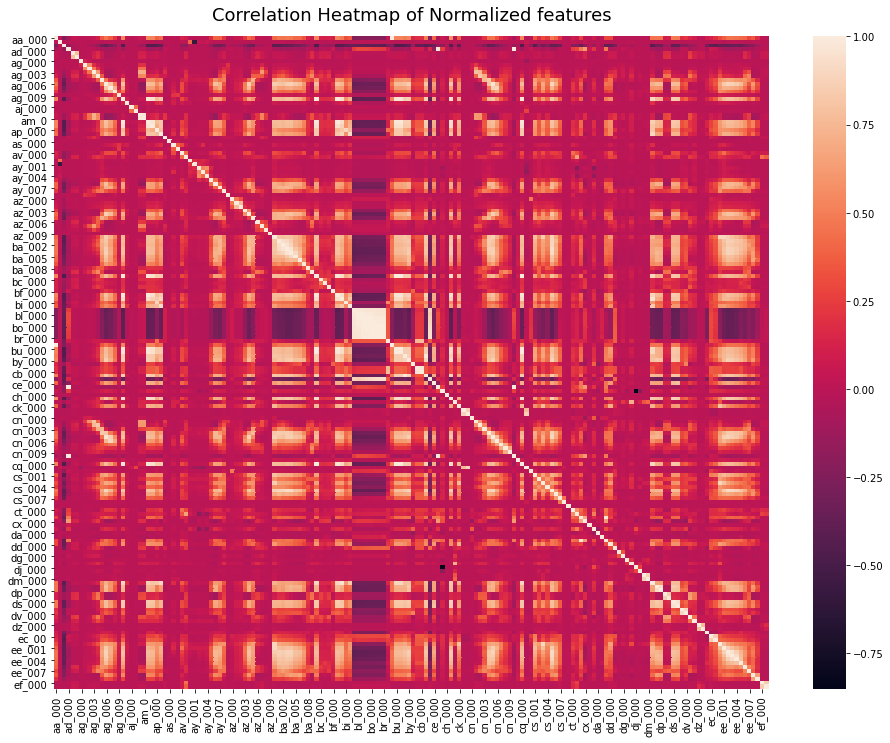

In [134]:
plt.figure(figsize=(16, 12))
heatmap_norm = sns.heatmap(cor_norm_X)
heatmap_norm .set_title('Correlation Heatmap of Normalized features', fontdict={'fontsize':18}, pad=16)

### iv. Pick b √ 170 c features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

Using simple imputed normalized data

In [18]:
# taking 13 features with best cv
best_n = cv_norm_aps.head(13).index
print(" The 13 features with best cv is:\n",best_n)


 The 13 features with best cv is:
 Index(['cs_009', 'dj_000', 'ch_000', 'ag_000', 'ak_000', 'ef_000', 'au_000',
       'as_000', 'az_009', 'dh_000', 'dz_000', 'df_000', 'eg_000'],
      dtype='object')


In [24]:
best_df = pd.concat([all_asp_feat.loc[:, best_n], aps_Y], axis= 'columns')
best_df

,cs_009,dj_000,ch_000,ag_000,ak_000,ef_000,au_000,as_000,az_009,dh_000,dz_000,df_000,eg_000,class
0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
1,0.0,0.0,3.437888e-11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
2,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
3,0.0,0.0,0.000000e+00,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.000018,neg
4,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN
75996,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN
75997,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN
75998,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN


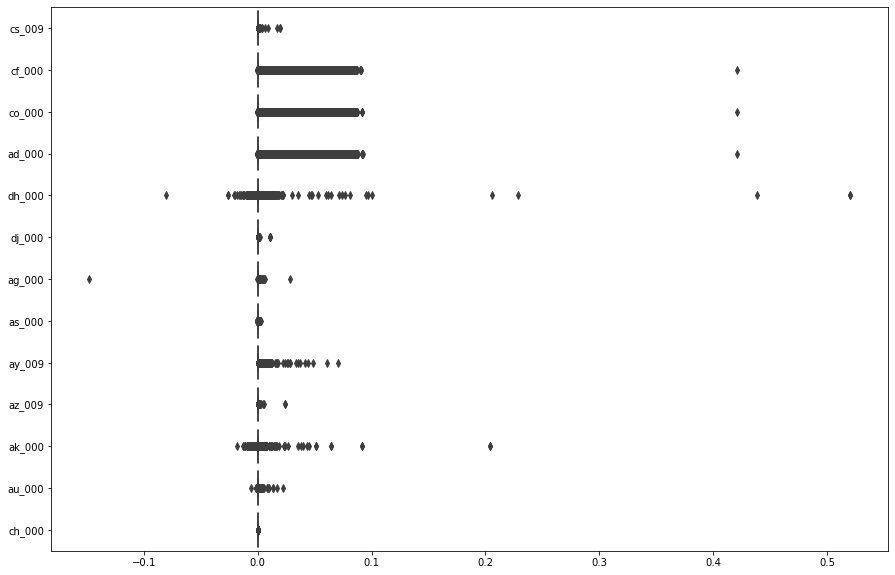

In [125]:
plt.figure(figsize=(15,10))
sns.boxplot(data=best_df, orient="h", palette="Set1")

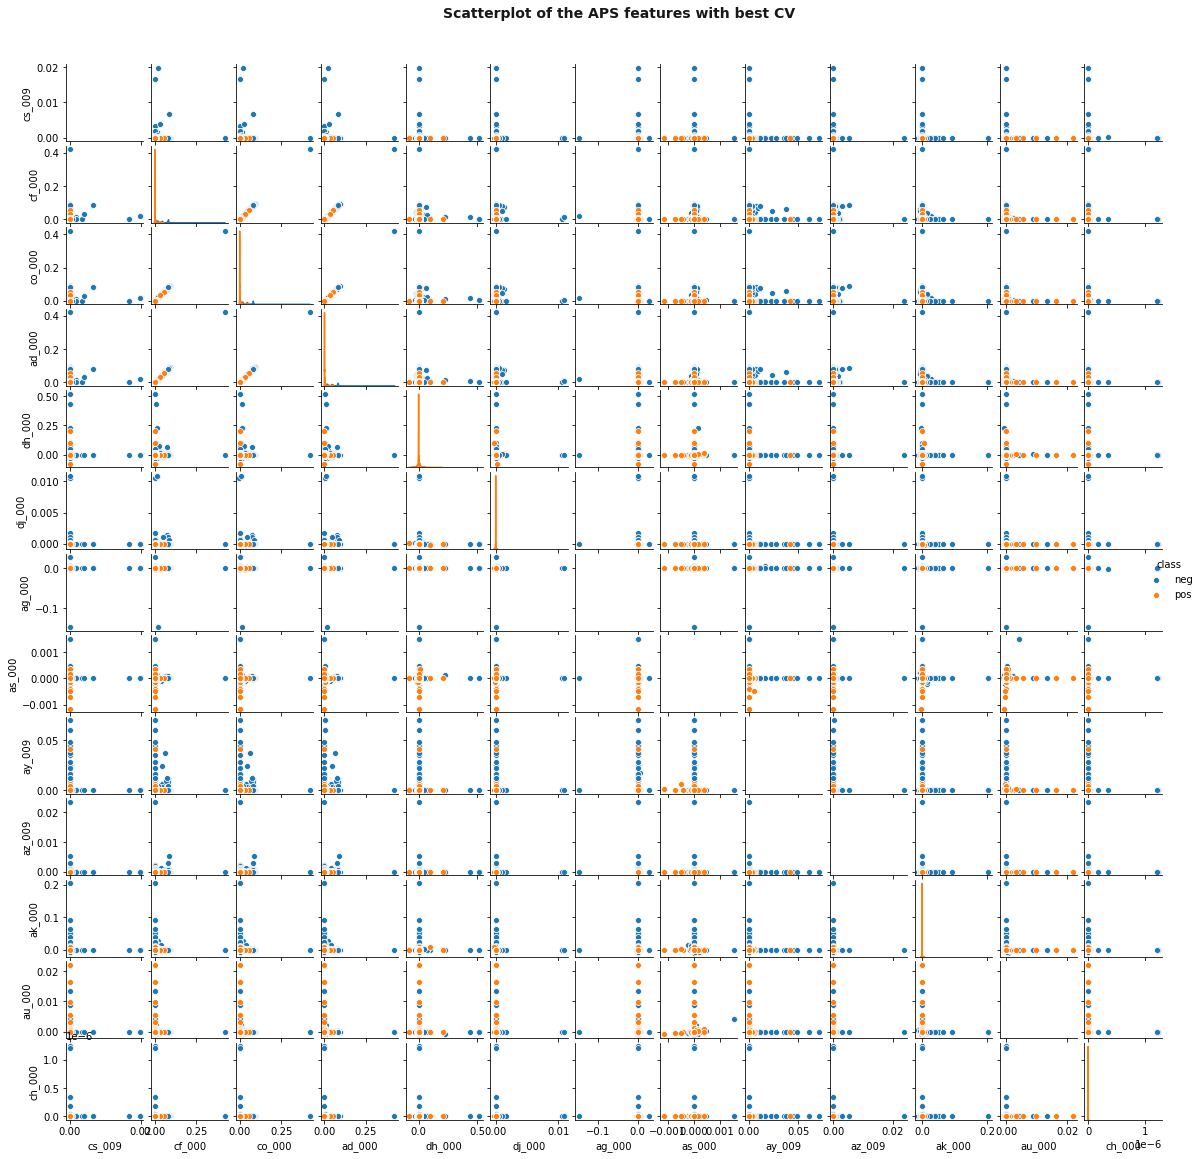

In [139]:
figure = sns.pairplot(best_df, diag_kind="kde",  hue="class")
figure.fig.set_size_inches(16,16)
plt.subplots_adjust(top = .93 )
figure.fig.suptitle("Scatterplot of the APS features with best CV  ", fontsize = 14, alpha = 0.9, weight = 'bold')
plt.show()

It is difficult to infer significance of the above 13 features  just by eyeballing the scatter plots.

###   v. Determine the number of positive and negative data. Is this data set imbal- anced? 

In [68]:
print(" Positive and Negatives in Training data\n",aps_Y.value_counts())
print(" Positive and Negatives in Testing data\n",aps_test_Y.value_counts())

 Positive and Negatives in Training data
 1    59000
0     1000
Name: class, dtype: int64
 Positive and Negatives in Testing data
 1    15625
0      375
Name: class, dtype: int64


Both training and testing dataset is heavely imbalanced

## (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

##### For training data

In [178]:
rand_forest = RandomForestClassifier(n_estimators=100,  random_state=0, oob_score=True)
rand_forest.fit(aps_train_norm, aps_Y)
train_error = 1 - accuracy_score(aps_Y, pred_train)
pred_train = rand_forest.predict(aps_train_norm)
cm_rand = confusion_matrix(aps_Y, pred_train)
print("Confusion matrix of training data:\n", cm_rand)
print("The train error is: ",train_error )
print("Accuracy: of the training set", accuracy_score(aps_Y, pred_train))

Confusion matrix of training data:
 [[59000     0]
 [    1   999]]
The train error is:  1.666666666666483e-05
Accuracy: of the training set 0.9999833333333333


There is 1 misclassification out of 60000 training set data

In [179]:
# getting probablity estimate
pred_train_pro = rand_forest.predict_proba(aps_train_norm)

# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr, tpr, thresholds  = metrics.roc_curve(aps_Y, pred_train_pro[:,1], pos_label='pos')
roc_auc_train = metrics.auc(fpr, tpr)
print(" The auc for training set is:",roc_auc_train)
 


 The auc for training set is: 1.0


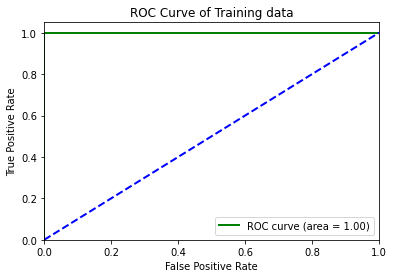

In [180]:
plt.plot(fpr, tpr, color='green',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Training data')
plt.legend(loc="lower right")
plt.show()

##### For testing data

In [196]:
#rand_forest.fit(aps_train_norm, aps_Y)
pred_test = rand_forest.predict(aps_test_norm_imp) 

cm_rand_test = confusion_matrix(aps_test_Y, pred_test)
print("Confusion matrix of testing data:\n", cm_rand_test)

print("Accuracy: of the imbalanced testing data", accuracy_score(aps_test_Y, pred_test))
test_error = 1 - accuracy_score(aps_test_Y, pred_test)
print("The test error is: ",test_error )

Confusion matrix of testing data:
 [[15610    15]
 [  132   243]]
Accuracy: of the imbalanced testing data 0.9908125
The test error is:  0.009187500000000015


There is 147 misclassification out of 16000 testing set data

In [182]:
# getting probablity estimate
pred_test_pro = rand_forest.predict_proba(aps_test_norm_imp)

# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr_t, tpr_t, thresholds  = metrics.roc_curve(aps_test_Y, pred_test_pro[:,1], pos_label='pos')
roc_auc_test = metrics.auc(fpr_t, tpr_t)
print(" The auc for testing set is:",roc_auc_test)
 


 The auc for testing set is: 0.9919313920000001


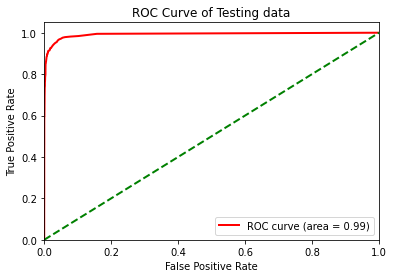

In [183]:
plt.plot(fpr_t, tpr_t, color='red',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Testing data')
plt.legend(loc="lower right")
plt.show()

In [184]:
oob_score = 1 - rand_forest.oob_score_
print("OOB score:", oob_score)
print("test error", test_error)

OOB score: 0.006833333333333358
test error 0.009187500000000015


The OOB error is little lower than Test error. OOB is much better to evaluate our model as compare to training error. As it overfits and give very high accuracy.

##  (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c. 

##### For training data 

Addressing imbalance in data

In [185]:
rf_bal = RandomForestClassifier(n_estimators=100,class_weight="balanced",  random_state=0, oob_score=True)
rf_bal.fit(aps_train_norm, aps_Y)
train_error_b = 1 - accuracy_score(aps_Y, pred_train)
pred_train = rf_bal.predict(aps_train_norm)
cm_rand = confusion_matrix(aps_Y, pred_train)
print("Confusion matrix of training data:\n", cm_rand)
print("The train error is: ",train_error_b )
print("Accuracy: of the training set", accuracy_score(aps_Y, pred_train))

Confusion matrix of training data:
 [[59000     0]
 [    0  1000]]
The train error is:  1.666666666666483e-05
Accuracy: of the training set 1.0


There is 0 misclassification out of 60000 training set data

In [187]:
# getting probablity estimate
pred_train_pro = rf_bal.predict_proba(aps_train_norm)

# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr, tpr, thresholds  = metrics.roc_curve(aps_Y, pred_train_pro[:,1], pos_label='pos')
roc_auc_train_b = metrics.auc(fpr, tpr)
print(" The auc for training set is:",roc_auc_train_b)
 


 The auc for training set is: 1.0


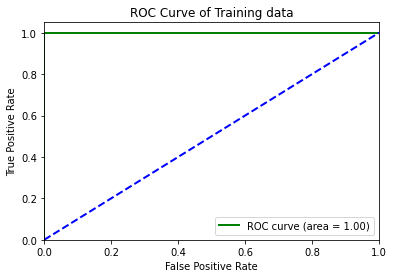

In [188]:
plt.plot(fpr, tpr, color='green',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_train_b)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Training data')
plt.legend(loc="lower right")
plt.show()

##### For testing data

In [195]:
#rand_forest.fit(aps_train_norm, aps_Y)
pred_test = rf_bal.predict(aps_test_norm_imp) 

cm_rand_test_b = confusion_matrix(aps_test_Y, pred_test)
print("Confusion matrix of testing data:\n", cm_rand_test_b)

print("Accuracy: of the balanced testing data", accuracy_score(aps_test_Y, pred_test))
test_error_b = 1 - accuracy_score(aps_test_Y, pred_test)
print("The test error is: ",test_error_b )

Confusion matrix of testing data:
 [[15614    11]
 [  178   197]]
Accuracy: of the balanced testing data 0.9881875
The test error is:  0.011812500000000004


There is 189 misclassification out of 16000 testing set data

In [191]:
# getting probablity estimate
pred_test_pro = rand_forest.predict_proba(aps_test_norm_imp)

# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr_t, tpr_t, thresholds  = metrics.roc_curve(aps_test_Y, pred_test_pro[:,1], pos_label='pos')
roc_auc_test_b = metrics.auc(fpr_t, tpr_t)
print(" The auc for testing set is:",roc_auc_test_b)
 


 The auc for testing set is: 0.9919313920000001


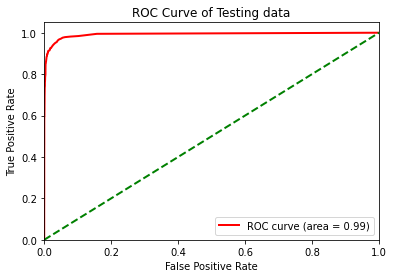

In [183]:
plt.plot(fpr_t, tpr_t, color='red',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Testing data')
plt.legend(loc="lower right")
plt.show()

In [193]:
oob_score_b = 1 - rf_bal.oob_score_
print("OOB score:", oob_score_b)
print("test error", test_error_b)

OOB score: 0.008016666666666672
test error 0.011812500000000004


**SUMMARY**

Accuracy of the Random forest model with unbalance compensation is 0.988. While accuracy of unbalanced data is 0.99, which is slightly more than the accuracy of the unbalance compensated model. In order to get high accuracy model might tend to predict sample as negative ,as negative sample is more than positive.

## (e) Model Trees In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used

In [29]:
imp_aps_train = aps_train_imp.copy()
imp_aps_train.loc[:, 'class'] = aps_Y
imp_aps_test = aps_test_imp.copy()
imp_aps_test.loc[:, 'class'] = aps_test_Y

In [30]:
# Saving imputed data as csv file
imp_aps_train.to_csv('../data/weka_train.csv', encoding='utf-8', index=False)
imp_aps_test.to_csv('../data/weka_test.csv', encoding='utf-8', index=False)

In [32]:
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\saman\\anaconda3\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\saman\\anaconda3\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\saman\\anaconda3\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'C:\\Users\\saman\\anaconda3\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'C:\\Users\\saman\\anaconda3\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [33]:
loader = Loader(classname="weka.core.converters.CSVLoader")

train_w = loader.load_file('../data/weka_train.csv')
test_w = loader.load_file('../data/weka_test.csv')

In [34]:
train_w.class_is_last()
test_w.class_is_last()

##### 5 fold cross validation

In [341]:
lmt_w =  Classifier(classname='weka.classifiers.trees.LMT')


##### Training data

In [342]:
evl_w = Evaluation(train_w)
evl_w.crossvalidate_model(classifier=lmt_w, data=train_w, num_folds = 5, rnd=Random(100))

In [343]:
print("Summary of training data with 5 fold:\n",evl_w.summary())

Summary of training data with 5 fold:
 
Correctly Classified Instances       59490               99.15   %
Incorrectly Classified Instances       510                0.85   %
Kappa statistic                          0.7212
Mean absolute error                      0.0114
Root mean squared error                  0.0841
Relative absolute error                 34.6202 %
Root relative squared error             65.7314 %
Total Number of Instances            60000     



In [226]:
print("Class details of the training data with 5 fold:\n",evl_w.class_details())

Class details of the training data with 5 fold:
 === Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.304    0.995      0.997    0.996      0.741    0.962     0.998     neg
                 0.696    0.003    0.797      0.696    0.743      0.741    0.962     0.741     pos
Weighted Avg.    0.992    0.299    0.992      0.992    0.992      0.741    0.962     0.993     



In [344]:
# report confusion matrix
print(evl_w.confusion_matrix)

[[58816.   184.]
 [  326.   674.]]


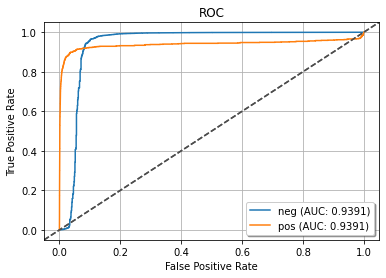

In [346]:
# plot ROC curve and get AUC
plcls.plot_roc(evl_w, class_index=[0, 1], wait=True)

In [384]:
lmt_w.build_classifier(train_w)

In [385]:
print(lmt_w)

Logistic model tree 
------------------

ag_001 <= 986
|   aq_000 <= 2197792
|   |   ag_002 <= 22938: LM_1:144/576 (57312)
|   |   ag_002 > 22938: LM_2:144/576 (313)
|   aq_000 > 2197792
|   |   ay_002 <= 17640
|   |   |   do_000 <= 709632: LM_3:144/720 (1673)
|   |   |   do_000 > 709632: LM_4:144/720 (74)
|   |   ay_002 > 17640: LM_5:144/576 (92)
ag_001 > 986: LM_6:144/288 (536)

Number of Leaves  : 	6

Size of the Tree : 	11



LM_1:
Class neg :
3.79 + 
[aa_000] * -0 +
[ab_000] * -0.02 +
[ae_000] * -0 +
[af_000] * 0    +
[ag_000] * 0    +
[ag_001] * -0 +
[ag_002] * 0    +
[ar_000] * -0.01 +
[as_000] * -0 +
[at_000] * -0 +
[au_000] * -0 +
[av_000] * -0 +
[ax_000] * 0    +
[ay_009] * -0 +
[az_001] * -0 +
[az_008] * 0    +
[bc_000] * -0 +
[bd_000] * 0    +
[be_000] * 0    +
[bf_000] * 0    +
[br_000] * -0 +
[bs_000] * -0 +
[by_000] * -0 +
[ca_000] * -0 +
[cg_000] * -0 +
[cl_000] * 0    +
[cm_000] * -0 +
[cp_000] * 0    +
[cs_000] * 0    +
[cs_007] * 0    +
[cs_008] * 0    +
[ct_000] * 0

##### Testing data

In [408]:
pred_test_Y = []

#Probablity estimate
pred_test_pro =[]

# loop through each instance of training data and make prediction
for ins in test_w:
    # loop through each instance of training data and make prediction

    pred_test_Y.append(lmt_w.classify_instance(inst))
    pred_test_pro.append(lmt_w.distribution_for_instance(inst))


In [392]:
# Converting to string type for conversion of value
pred_test_Y  = np.array(pred_test_Y).astype('str')

# Changing values back to neg and pos
pred_test_Y[pred_test_Y  == '0.0'] = 'neg'
pred_test_Y[pred_test_Y == '1.0'] = 'pos'
pred_test_pro  = np.array(pred_test_pro )

In [394]:

cm_rand_test_w = confusion_matrix(aps_test_Y, pred_test_Y)
print("Confusion matrix of weka testing data:\n", cm_rand_test_w)

print("Accuracy: of the balanced training data", accuracy_score(aps_test_Y, pred_test_Y))
test_error_w = 1 - accuracy_score(aps_test_Y, pred_test_Y)
print("The train error is: ",test_error_w )


# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr_w, tpr_w, thresholds  = metrics.roc_curve(aps_test_Y, pred_test_pro[:,1], pos_label='pos')
roc_auc_test_w = metrics.auc(fpr_w, tpr_w)
print(" The auc for training set is:",roc_auc_test_w)
 

Confusion matrix of weka testing data:
 [[15625     0]
 [  375     0]]
Accuracy: of the balanced training data 0.9765625
The train error is:  0.0234375
 The auc for training set is: 0.5


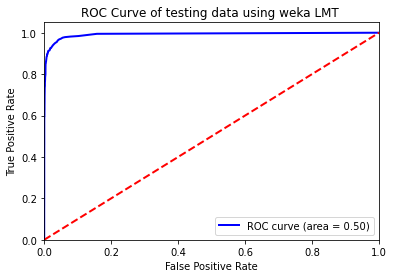

In [395]:
plt.plot(fpr_t, tpr_t, color='blue',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_test_w)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of testing data using weka LMT ')
plt.legend(loc="lower right")
plt.show()

In [277]:
#pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


## f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE

##### Using 5 cross validation

In [297]:

sf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
smt_error = []
s_lmt = Classifier(classname='weka.classifiers.trees.LMT')

# For each cv, apply smote
for train_index, valid_index in sf.split(aps_train_imp, aps_Y):
    
    # Seprating predictor and response for each cv
    tra_x = aps_train_imp.iloc[train_index]
    val_x = aps_train_imp.iloc[valid_index]
    tra_y = aps_Y[train_index]
    val_y = aps_Y[valid_index]
    std_tra_x = stdscaler(tra_x)
    smt = SMOTE()
    sm_tra_x, sm_tra_y = smt.fit_resample(std_tra_x, tra_y.ravel())
#     print(sm_tra_x.iloc[:,2])
#     print(std_tra_x.columns[2])
    sm_tra_x = {std_tra_x.columns[i]: sm_tra_x.iloc[:,i] for i in range(len(std_tra_x.columns))}
    sm_tra_x = pd.DataFrame.from_dict(sm_tra_x)
    pd_tra = pd.concat([pd.DataFrame({'class':sm_tra_y}), sm_tra_x], axis = 1)
    pd_tra.to_csv('../data/pd_tra.csv', encoding='utf-8', index=False)
    wekapd_tra = loader.load_file('../data/pd_tra.csv')
    wekapd_tra.class_index = 0
    smote_eval = Evaluation(wekapd_tra)
    cls = Classifier.make_copy(s_lmt)
    cls.build_classifier(wekapd_tra)
    std_val_x = stdscaler(val_x)
    val_y = val_y.reset_index(drop=True)
    pd_val = pd.concat([val_y, std_val_x], axis = 1)
    pd_val.to_csv('../data/pd_val.csv', encoding='utf-8', index=False)
    wekapd_val = loader.load_file('../data/pd_val.csv')
    wekapd_val.class_index = 0
    smote_eval.test_model(cls, wekapd_val)
    smt_error.extend([smote_eval.percent_correct])
    print("Cross Validation {} / 5 finished".format(len(smt_error)))


Cross Validation 1 / 5 finished
Cross Validation 2 / 5 finished
Cross Validation 3 / 5 finished
Cross Validation 4 / 5 finished
Cross Validation 5 / 5 finished


In [298]:
smt_error

[96.75, 93.35, 53.65, 92.41666666666667, 94.075]

In [336]:
print(" Percent correct of 5-fold cross validation on data sampled via SMOTE is:\n",np.mean(smt_error))

 Percent correct of 5-fold cross validation on data sampled via SMOTE is:
 86.04833333333333


In [339]:
print(" Test error of 5-fold cross validation on data sampled via SMOTE is:\n",(100 - np.mean(smt_error)))

 Test error of 5-fold cross validation on data sampled via SMOTE is:
 13.951666666666668


In [313]:
# SMOTE on the whole training dataset
smote_weka_trainX, smote_weka_trainY = smt.fit_resample(aps_train_imp, aps_Y)

In [314]:
# save SMOTE trainning set as CSV
smote_train_path = '../data/smote_weka_train.csv'
smote_weka_trainX.loc[:, 'class'] = smote_weka_trainY
smote_weka_trainX.to_csv('../data/smote_trainX.csv', index=False)

In [316]:
train_smoteX = loader.load_file('../data/smote_trainX.csv')
train_smoteX .class_is_last()


###### For Training data

In [317]:
smote_lmt = Classifier(classname='weka.classifiers.trees.LMT')

# Building classifier with the training data
smote_lmt.build_classifier(train_smoteX )

In [304]:
weka_train_predict = []
weka_train_proba = []

# Loop through each instance and make prediction
for inst in train_smoteX:
    weka_train_predict.append(smote_lmt.classify_instance(inst))
    weka_train_proba.append(smote_lmt.distribution_for_instance(inst))

# Converting to string type for conversion of value
weka_train_predict = np.array(weka_train_predict).astype('str')

# Changing values back to neg and pos
weka_train_predict[weka_train_predict == '0.0'] = 'neg'
weka_train_predict[weka_train_predict == '1.0'] = 'pos'
weka_train_proba = np.array(weka_train_proba)

In [321]:
# Report confusion matrix, ROC, AUC
cm_smoke_train = confusion_matrix(smote_weka_trainY, weka_train_predict)
print("Confusion matrix of smote weka training data:\n", cm_smoke_train)

print("Accuracy: of the balanced training data", accuracy_score(smote_weka_trainY, weka_train_predict))
train_error_smote= 1 - accuracy_score(smote_weka_trainY, weka_train_predict)
print("The train error is: ",train_error_smote )

# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr, tpr, thresholds  = metrics.roc_curve(smote_weka_trainY, weka_train_proba[:,1], pos_label='pos')
roc_auc_train_smote = metrics.auc(fpr, tpr)
print(" The auc for training set is:",roc_auc_train_smote)
 

Confusion matrix of smote weka training data:
 [[57607  1393]
 [  520 58480]]
Accuracy: of the balanced training data 0.9837881355932203
The train error is:  0.016211864406779686
 The auc for training set is: 0.9972907395863257


There is 1913 misclassification out of 118000 testing set data

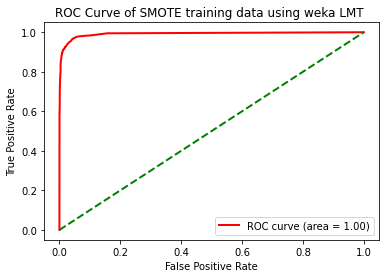

In [340]:
plt.plot(fpr_t, tpr_t, color='red',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_train_smote)
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SMOTE training data using weka LMT ')
plt.legend(loc="lower right")
plt.show()

##### For testing data

In [326]:
# Standardizing test set and creating csv file
smote_std_test_X = stdscaler(aps_test_imp)
smote_test = pd.concat([smote_std_test_X, aps_test_Y], axis = 1)
smote_test.to_csv('../data/smote_test.csv', encoding='utf-8', index=False)

In [327]:
smote_test_csv = loader.load_file('smote_test.csv')
smote_test_csv.class_is_last()

In [331]:
weka_test_predict = []
weka_test_pro = []

# Loop through each instance and make prediction
for inst in smote_test_csv:
    weka_test_predict.append(smote_lmt.classify_instance(inst))
    weka_test_pro.append(smote_lmt.distribution_for_instance(inst))
    
# Converting to string time for conversion of value
weka_test_predict = np.array(weka_test_predict).astype('str')

# Changing values back to neg and pos
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_pro = np.array(weka_test_pro)

In [332]:
# Report confusion matrix, AUC, ROC
cm_smoke_test = confusion_matrix(aps_test_Y, weka_test_predict)
print("Confusion matrix of smote weka testing data:\n", cm_smoke_test)

print("Accuracy: of the balanced testing data", accuracy_score(aps_test_Y, weka_test_predict))
test_error_smote= 1 - accuracy_score(aps_test_Y, weka_test_predict)
print("The test error is: ",test_error_smote )

# Specifying labels as Scikit-learn assumes that data given to it will always have labels 0 and 1 
fpr, tpr, thresholds  = metrics.roc_curve(aps_test_Y, weka_test_pro[:,1], pos_label='pos')
roc_auc_test_smote = metrics.auc(fpr, tpr)
print(" The auc for testing set is:",roc_auc_test_smote)
 

Confusion matrix of smote weka testing data:
 [[15616     9]
 [  371     4]]
Accuracy: of the balanced testing data 0.97625
The test error is:  0.02375000000000005
 The auc for testing set is: 0.13642376533333334


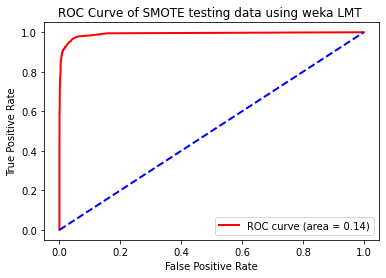

In [335]:
plt.plot(fpr_t, tpr_t, color='red',lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_test_smote)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SMOTE testing data using weka LMT ')
plt.legend(loc="lower right")
plt.show()

In [35]:
jvm.stop()

**Summary**

Accuracy of SMOTE test data is 97.63 while accuracy of weka uncompensated  data is : 97.67.

Performance of LMT model with SMOTE is little poor as compared to performance of LMT with uncompensated  data.
If we compare confusion matrix SMOTE has btter precision 4 out of 375 as compared to uncompensated data 0 out of 375. This indicates SMOTE can increase the classification of minority class at the cost of reducing accuracy.

# ISLR

### 6.8.3 Suppose we estimate the regression coefficients in a linear regression
model by minimizing 
i=1
⎛
⎝yi − β0 −p
j=1
βjxij
⎞
⎠
2
subject to p
j=1
|βj | ≤ s
for a particular value of s. For parts (a) through (e), indicate which
of i. through v. is correct. Justify your answer.



(a) As we increase s from 0, the training RSS will:
i. Increase initially, and then eventually start decreasing in an
inverted U shape.
ii. Decrease initially, and th`men eventually start increasing in a
U shape.
iii. Steadily increase.
iv. Steadily decrease.
v. Remain constant.

iv) Steadily decrease.
As s increases the restriction of estimate of coefficient decreases. Model becomes flexible and thus RSS decreases steadily



(b) Repeat (a) for test RSS.

 ii) Decrease initially, and then eventually start increasing in a U shape

With increase in s, the restriction on estimated coefficients decreases and flexibility of model increases.  Thus the test RSS decreases initially till the point of overfit. After that point it starts increasing again and thus a U shape.

(c) Repeat (a) for variance.

iii) - steadily increase.

With increase in s, the restriction due to constraint on estimated coefficient decreases. Thus model flexibility increases , which leads to increase in variance. Variance stops increasing further  , if the least square falls within the constrain region.

(d) Repeat (a) for (squared) bias.
As stated above with increase in s there is decrease in  shrinkage. And the model's flexibility increases and bias decreases.


iv) - steadily decrease

Same reasoning as part (c) - increasing the flexibility will decrease the bias. Again, this will stop reducing if the least squares solution falls within the constraint region.

e) Repeat (a) for the irreducible err

 v. - remain constant.

The irreducible error is independent of the features and hence it is independet of size s

### . It is well-known that ridge regression tends to give similar coefficient
values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore
this property in a very simple setting.
Suppose that n = 2, p = 2, x11 = x12, x21 = x22. Furthermore,
suppose that y1 +y2 = 0 and x11 +x21 = 0 and x12 +x22 = 0, so that
the estimate for the intercept in a least squares, ridge regression, or
lasso model is zero: βˆ0 = 0.





(a) Write out the ridge regression optimization problem in this setting.

(b) Argue that in this setting, the ridge coefficient estimates satisfy
βˆ1 = βˆ2.

(c) Write out the lasso optimization problem in this setting.

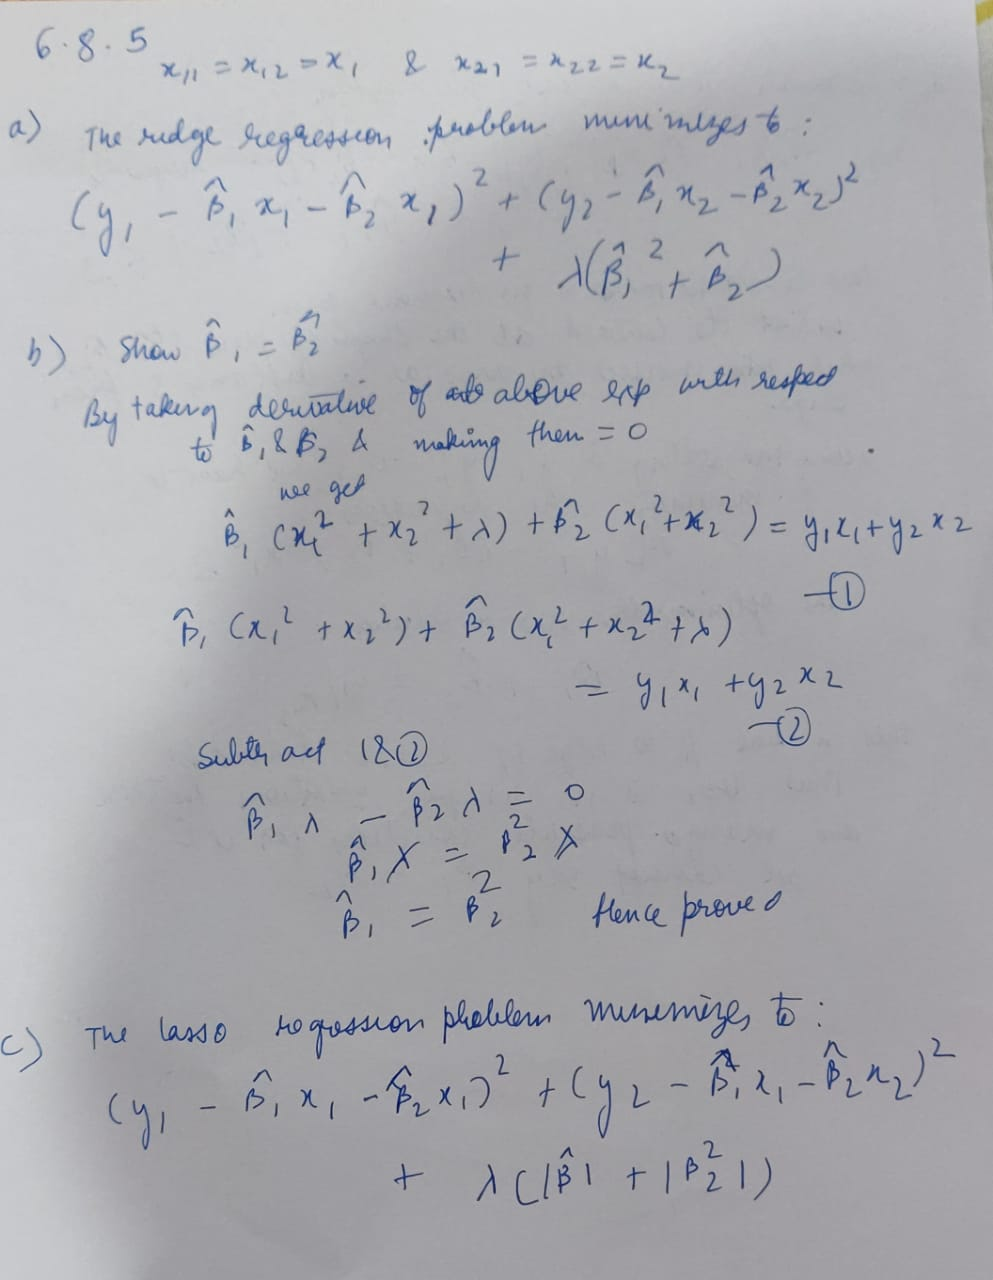

(d) Argue that in this setting, the lasso coefficients βˆ1 and βˆ2 are
not unique—in other words, there are many possible solutions
to the optimization problem in (c). Describe these solutions

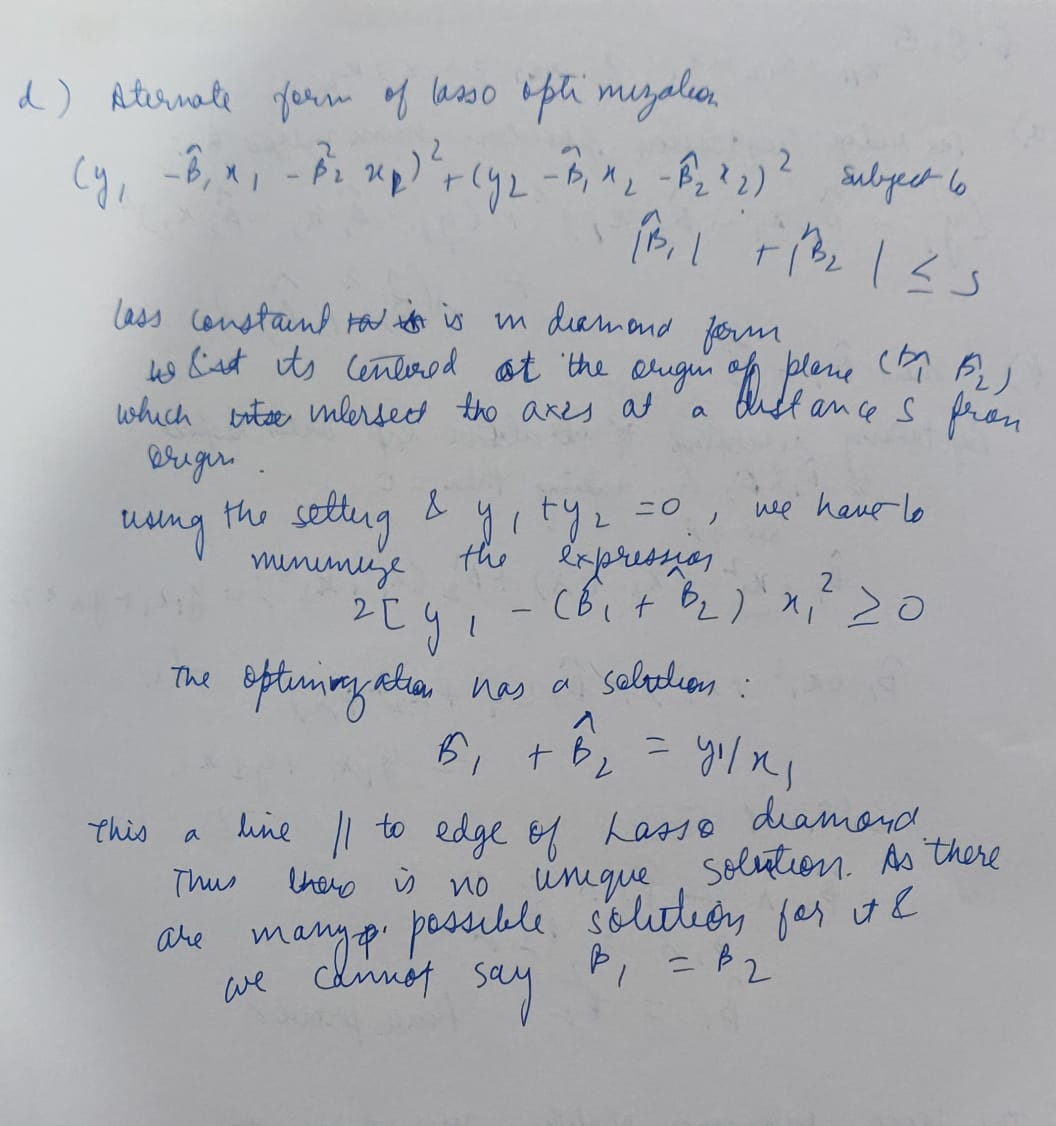


### 8.4.5. Suppose we produce ten bootstrapped samples from a data set
containing red and green classes. We then apply a classification tree
to each bootstrapped sample and, for a specific value of X, produce
10 estimates of P(Class is Red|X):
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75.8.4 Exercises 333

FIGURE 8.12. Left: A partition of the predictor space corresponding to Exercise 4a. Right: A tree corresponding to Exercise 4b.
There are two common ways to combine these results together into a
single class prediction. One is the majority vote approach discussed in
this chapter. The second approach is to classify based on the average
probability. In this example, what is the final classification under each
of these two approaches

###### Majority Vote

Red:
The no of red prediction (6: for p >= 0.5) is more than no of green prediction (4: for p < 0.5) 

###### Avg Probability

Green : Mean found is 0.45, which is less than 0.5 so answer is green

### 9.7.3 3. Here we explore the maximal margin classifier on a toy data set.
(a) We are given n = 7 observations in p = 2 dimensions. For each
observation, there is an associated class label.9.7 Exercises 369
Obs. X1 X2 Y
1 3 4 Red
2 2 2 Red
3 4 4 Red
4 1 4 Red
5 2 1 Blue
6 4 3 Blue
7 4 1 Blue
Sketch the observations.


In [348]:
from sklearn.svm import SVC

In [350]:
input_df = pd.DataFrame( {'X1' : [3, 2, 4, 1, 2, 4, 4], 'X2' : [4, 2, 4, 4, 1, 3, 1],\
                          'Y' : ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']})

In [353]:
input_X = input_df.drop(columns= 'Y')
input_y = input_df['Y']

0     red
1     red
2     red
3     red
4    blue
5    blue
6    blue
Name: Y, dtype: object

In [354]:
#  fit the model
svc = SVC(kernel='linear', C=10000)
svc.fit(input_X, input_y)

SVC(C=10000, kernel='linear')

In [357]:
input_X.iloc[:, 0]

0    3
1    2
2    4
3    1
4    2
5    4
6    4
Name: X1, dtype: int64

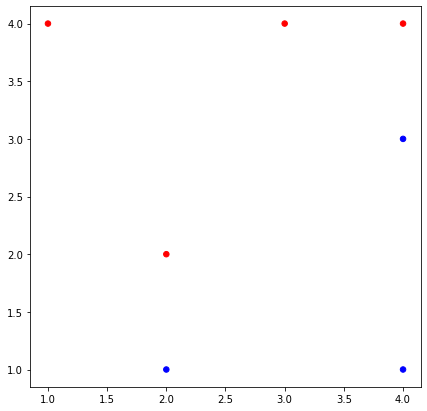

In [366]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(input_X.iloc[:, 0], input_X.iloc[:, 1], c=input_y, s=30, cmap=plt.cm.Paired)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc.decision_function(xy).reshape(XX.shape)



(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).


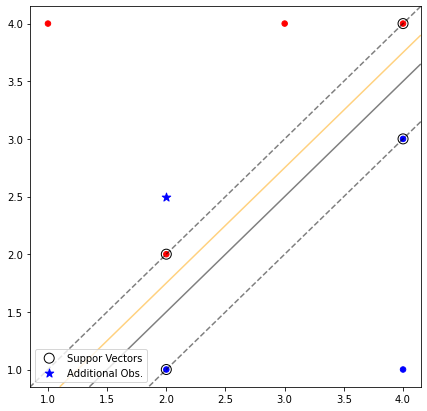

In [383]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(input_X.iloc[:, 0], input_X.iloc[:, 1], c=input_y, s=30, cmap=plt.cm.Paired)


# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc.decision_function(xy).reshape(XX.shape)

# hyperplane
lines1 = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], label="Decision Boundary")

# support vectors
ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label="Suppor Vectors")

# Hyperplane which is not optimal
lines2 = ax.contour(XX, YY, Z - 0.5, colors='orange', levels=[0], alpha=0.5, linestyles=['-'], lw = 3)

# Obs that makes two classes not linearly seprable
ax.scatter([2.0], [2.5], color='blue', marker="*", s = 80, label="Additional Obs.")

ax.legend()
plt.show()



The middle black line

(c) Describe the classification rule for the maximal margin classifier.
It should be something along the lines of “Classify to Red if
β0 + β1X1 + β2X2 > 0, and classify to Blue otherwise.” Provide
the values for β0, β1, and β2.


Classify to Red : −1/2 + X1 − X2 ≤0

Classify to Blue : −1/2 + X1 − X2 >0

(d) On your sketch, indicate the margin for the maximal margin
hyperplane.


The --- line in the above figure

(e) Indicate the support vectors for the maximal margin classifier.


The point on the margin in the above figure marked by white transparent circle

(f) Argue that a slight movement of the seventh observation would
not affect the maximal margin hyperplane.


The seventh observation is not a support vector as it is away from the max margin hyperplane.Thus it's slight movement does not affect the maximal margin hyperplane.

(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.


The orange line in the above diagram

(h) Draw an additional observation on the plot so that the two
classes are no longer separable by a hyperplane

The blue star in above figure

**References**

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-
https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7
https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
https://xgboost.readthedocs.io/en/latest/parameter.html
https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
https://scikit-learn.org/stable/modules/impute.html
https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py
https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
https://stats.stackexchange.com/questions/226109/how-does-predict-randomforest-estimate-class-
https://fracpete.github.io/python-weka-wrapper3/examples.html
https://python.hotexamples.com/examples/weka.classifiers/Evaluation/test_model/python-evaluation-test_model-method-examples.html
https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
http://fracpete.github.io/python-weka-wrapper3/weka.html#weka.classifiers.Evaluation.test_model